In [ ]:
from collections import defaultdict

gff_annotation_file = "C:/Users/admin/branchpoint/GRCh38_latest_genomic.gff" #your path to gff file

genes = {}
exons = defaultdict(list)

with open(gff_annotation_file) as f:
    for line in f:
        if line.startswith("#"):
            continue
        d = line.strip().split("\t")
        d[2] = d[2].lower()
        d[3] = int(d[3])
        d[4] = int(d[4])
        features = dict([x.split("=") for x in d[-1].split(";")])
        if "Dbxref" in features:
            features["Dbxref"] = dict([x.split(":")[:2] for x in features["Dbxref"].split(",")])
        d[-1] = features
        if d[2] == "gene":
            if features["gene_biotype"] != "protein_coding":
                continue
            gene_id = features["Dbxref"]["GeneID"]
            genes[gene_id] = list([d[3], d[4], d[6]])
        if d[2] == "exon":
            gene_id = features["Dbxref"]["GeneID"]
            parent = features["Parent"]
            if gene_id in genes:
                exons[gene_id].append(list([d[0], d[3], d[4], d[6], parent]))

introns = defaultdict(list)
for gene in genes:
    intron_file = open("intr/" + str(gene) + ".bed", "w")
    strand = genes[gene][2]
    exons_list = exons[gene]
    if strand == "+":
        for i in range(len(exons_list) - 1):
            if strand != exons_list[i][3]:
                break
            parent = exons_list[i][4]
            if exons_list[i+1][4] == parent:
                introns[gene].append([exons_list[i][2] + 1, exons_list[i+1][1] - 1])
                intron_file.write("{}\t{}\t{}\t.\t.\t{}\n".format(exons_list[i][0], exons_list[i+1][1] - 61,
                                                                  exons_list[i+1][1] - 1, strand))

    if strand == "-":
        for i in range(len(exons_list) - 1):
            if strand != exons_list[i][3]:
                break
            parent = exons_list[i][4]
            if exons_list[i + 1][4] == parent:
                introns[gene].append([exons_list[i+1][2] + 1, exons_list[i][1] - 1])
                intron_file.write("{}\t{}\t{}\t.\t.\t{}\n".format(exons_list[i][0], exons_list[i+1][2],
                                                                  exons_list[i+1][2] + 60, strand))
    intron_file.close()

In [59]:
from weblogo import *

def make_logo (filename):
    filepath = 'C:/Users/admin/PycharmProjects/branchpoint/'
    f = open('{}fasta_logo/{}'.format(filepath, filename))
    seqs = read_seq_data(f, alphabet='ACGTacgt')
    logo_data = LogoData.from_seqs(seqs)
    logo_options = LogoOptions()
    logo_options.color_scheme = classic
    logo_options.stacks_per_line = 60
    logo_format = LogoFormat(logo_data, logo_options)
    jpeg = jpeg_formatter(logo_data, logo_format)
    with open('{}logos/logo_{}.jpeg'.format(filepath, filename.split(".")[0]), 'wb') as f:
            f.write(jpeg)

In [17]:
bed_file_list = !dir intr /s /b

In [18]:
def remove_duplicates(filename):
    str_list = []
    with open(filename, "r") as f:
        for line in f:
            if line not in str_list:
                str_list.append(line)

    out = open(filename, 'w')
    for line in str_list:
        out.write(line)
    out.close()

In [19]:
for file in bed_file_list:
    remove_duplicates(file)

In [20]:
%%bash
# mkdir fasta_logo
cd intr
files=`dir`
cd ..
for f in $files;
do
    bedtools getfasta -fi /mnt/c/Users/admin/branchpoint/GRCh38_latest_genomic.fna -bed intr/$f -s > /mnt/c/users/admin/PycharmProjects/branchpoint/fasta_logo/${f%.*}.fa
    if [ -s fasta_logo/${f%.*}.fa ]; then 
        awk '/^>/ {print($0)}; /^[^>]/ {print(toupper($0))}' fasta_logo/${f%.*}.fa > fasta_logo/${f%.*}_upper.fa; 
    fi
    rm fasta_logo/${f%.*}.fa
done

In [1]:
fasta_file_list = !dir fasta_logo /s /b
for file in fasta_file_list:
    make_logo(file.split("\\")[-1])

(1.0, 60.0)

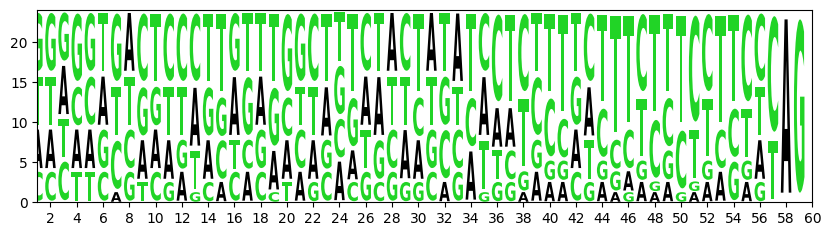

In [55]:
#the sesond way to make a logo, A will be black, CGT green
import logomaker as lm
import numpy as np
from Bio import SeqIO
def read_from_fasta(file):
    fasta_sequences = list(SeqIO.parse(open(file), "fasta"))
    return [str(x.seq) for x in fasta_sequences]
seqs = read_from_fasta("fasta_logo/9656_upper.fa")
counts_mat = lm.alignment_to_matrix(seqs)
counts_mat= counts_mat / 6
seq_logo = lm.Logo(counts_mat, vpad=.1,
                         width=.8, color_scheme="weblogo_protein")

seq_logo.ax.set_xticks(np.arange(0,len(counts_mat)+4,2))
seq_logo.ax.set_xlim([1, len(counts_mat)])